In [1]:
%cd ..

C:\Users\efurst1\PycharmProjects\LIDC_GDRO


In [2]:
import data_util
import models
import torch
import loss
import train
import pandas as pd
import numpy as np

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"

training_fraction = 0.8
batch_size = 160
proportional = True

is_gdro = True

hparams = {"groupdro_eta": 0.1}

In [4]:
subtype_df = pd.read_csv("data/lidc_spic_subgrouped_radiologist.csv")

# import data
df = pd.read_csv("data/LIDC_individual_radiologists.csv")
# preprocess data (normalization, remove anything that isn't in the chosen features)
df = data_util.preprocess_data(df)

In [94]:
sum(df["malignancy"] == 0) / len(df)

0.6133909287257019

In [5]:
# get train/test flags
train_test = pd.read_csv("data/lidc_train_test_radiologist.csv")

# create train/test dataframes
training_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "train"]["noduleID"].values)]
test_df = df[df["noduleID"].isin(train_test[train_test["dataset"] == "test"]["noduleID"].values)]

# use noduleIDs as index, it makes things easier
subtype_df.index = subtype_df["noduleID"].values

# Test convergence of combinations of ERM and GDRO

In [72]:
N = 30
epochs = 100
subtypes = ["Overall", "Unspiculated benign", "Spiculated benign", "Spiculated malignant", "Unspiculated malignant"]

test_algorithms = ["Sharp", "Smooth"]

results = {algorithm: np.zeros(epochs * len(subtypes)) for algorithm in test_algorithms}
for algorithm in test_algorithms:

    print("Running test: " + algorithm)

    # create the training and testing dataloaders
    train_dataloader = data_util.create_subtyped_dataloader(training_df, subtype_df, batch_size, proportional)
    test_dataloader = data_util.create_subtyped_dataloader(test_df, subtype_df, batch_size, proportional)

    for n in range(N):

        print(f"Trial {n + 1}/{N}")

        # create and train model
        model = models.NeuralNetwork(64, 32, 32, 2)
        model.to(device)

        loss_fn = loss.ERMGDROLoss(model, torch.nn.CrossEntropyLoss(), hparams)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.005)

        for epoch in range(epochs):
            if algorithm == "Sharp":
                loss_fn.t = epoch / epochs < 0.5  # sharp boundary
            elif algorithm == "Smooth":
                loss_fn.t = 1 - (epoch / (epochs - 1))  # linear interpolation
            train.train(train_dataloader, model, loss_fn, optimizer)
            sensitivities = train.test(test_dataloader, model)
            
            for i in range(len(subtypes)):
                results[algorithm][i * epochs + epoch] += sensitivities[i]
    
    results[algorithm] /= N

results_df = pd.DataFrame(results, index=pd.MultiIndex.from_product([subtypes, range(epochs)], names=["subtype", "epoch"]))

print("Test complete")

Running test: Sharp
Trial 1/30
Trial 2/30
Trial 3/30
Trial 4/30
Trial 5/30
Trial 6/30
Trial 7/30
Trial 8/30
Trial 9/30
Trial 10/30
Trial 11/30
Trial 12/30
Trial 13/30
Trial 14/30
Trial 15/30
Trial 16/30
Trial 17/30
Trial 18/30
Trial 19/30
Trial 20/30
Trial 21/30
Trial 22/30
Trial 23/30
Trial 24/30
Trial 25/30
Trial 26/30
Trial 27/30
Trial 28/30
Trial 29/30
Trial 30/30
Running test: Smooth
Trial 1/30
Trial 2/30
Trial 3/30
Trial 4/30
Trial 5/30
Trial 6/30
Trial 7/30
Trial 8/30
Trial 9/30
Trial 10/30
Trial 11/30
Trial 12/30
Trial 13/30
Trial 14/30
Trial 15/30
Trial 16/30
Trial 17/30
Trial 18/30
Trial 19/30
Trial 20/30
Trial 21/30
Trial 22/30
Trial 23/30
Trial 24/30
Trial 25/30
Trial 26/30
Trial 27/30
Trial 28/30
Trial 29/30
Trial 30/30
Test complete


In [73]:
results_df

Sharp    Smooth
subtype                epoch                    
Overall                0      0.804025  0.800881
                       1      0.812411  0.814256
                       2      0.817652  0.820964
                       3      0.821845  0.825744
                       4      0.826415  0.827128
...                                ...       ...
Unspiculated malignant 95     0.774933  0.765600
                       96     0.785600  0.748267
                       97     0.774133  0.759733
                       98     0.752800  0.753867
                       99     0.753600  0.738400

[500 rows x 2 columns]

In [ ]:
"""
Test parameters

input: 64 engineered features extracted from lidc max-slice images

model layer sizes = (64, 32, 32, 2)
groupdro_eta = 0.1
lr = 0.001
weight_decay = 0.005

batch_size = 40
proportional = True
epochs = 40
N = 120

"""

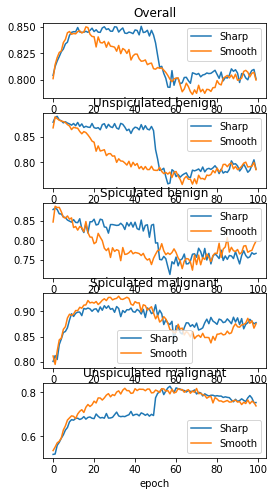

In [74]:
import matplotlib.pyplot as plt

# results_df.unstack(level=0).plot(subplots=True)

f, a = plt.subplots(len(subtypes),1)
for i in range(len(subtypes)):
    results_df.xs(subtypes[i]).plot(kind='line',title=subtypes[i],ax=a[i],figsize=(4,8))

In [88]:
from scipy.stats import ttest_ind
import statistics

# group_names = ["Overall", "GE MEDICAL SYSTEMS", "Unknown", "SIEMENS", "TOSHIBA", "Philips"]
group_names = ["Overall", "unmarked_benign", "marked_benign", "marked_malignant", "unmarked_malignant"]
# group_names = ["Overall", "0benign", "1benign", "0malignant", "1malignant"]
for i in range(5):
    print(group_names[i])
#     print(f"Mean ERM accuracy: {statistics.mean(data_clean[i]['ERM'])}")
#     print(f"Mean GDRO accuracy: {statistics.mean(data_clean[i]['GDRO'])}")
#     print(f"Mean Combined accuracy: {statistics.mean(data_clean[i]['Combined'])}")
    print(f"Mean Sharp accuracy: {statistics.mean(data_clean[i]['Sharp'])}")
    print(f"Mean Smooth accuracy: {statistics.mean(data_clean[i]['Smooth'])}")
    stat, p = ttest_ind(data_clean[i]["Sharp"], data_clean[i]["Smooth"])
    if p < 0.05:
        print(f"{'Sharp' if stat > 0 else 'Smooth'} higher accuracy (p = {p})")
    else:
        print(f"No statistically significant difference (p = {p})")
    print()
    

Overall


TypeError: 'numpy.float64' object is not iterable

In [ ]:
# old results with flawed malignancy labels + CNN subtypes
data_clean0